# Creating river forcing

In [1]:
from roms_tools import RiverForcing, Grid

We first create our grid object. In this example, our domain lives in the North Atlantic and surrounds Iceland.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=800, size_y=800, center_lon=-18, center_lat=65, rot=20
)

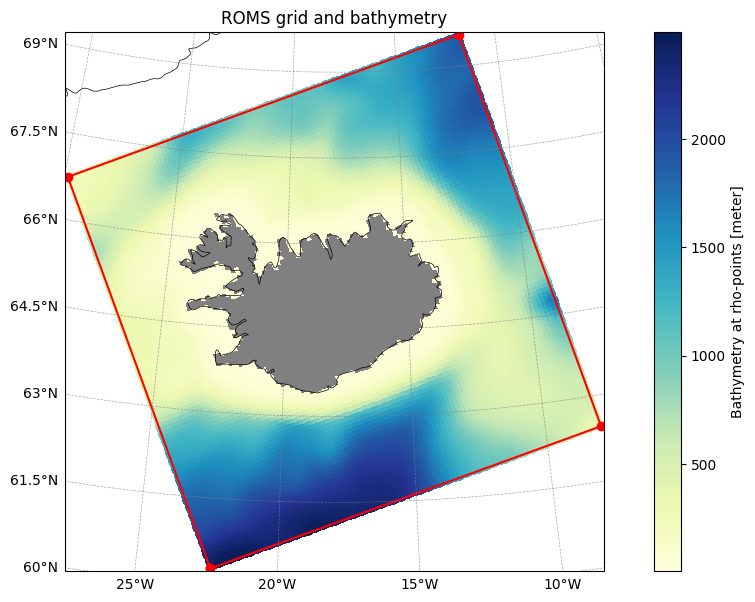

In [3]:
grid.plot(bathymetry=True)

We aim to generate river forcing data for the years 1998, 1999, and 2000.

In [4]:
from datetime import datetime

In [5]:
start_time = datetime(1998, 1, 1)
end_time = datetime(2000, 12, 31)

In [6]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
)

INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
INFO - Compute climatology for river forcing.


CPU times: user 649 ms, sys: 208 ms, total: 857 ms
Wall time: 1.48 s


<div class="alert alert-info">

Note

The river forcing dataset includes a parameter called `source`. If this parameter is not specified by the user, it defaults to the **Dai and Trenberth global river dataset** (updated in May 2019), which provides monthly time series for approximately 1,000 rivers worldwide, dating back to the year 1900. This default dataset is downloaded internally, meaning the user does not need to provide a file path or filename. 
    
You can also include your own river dataset by specifying the `source` parameter as follows:

```
source = {
    "name": "DAI",
    "path": "path/to/file",
    "climatology": True / False
}
```
where the dataset at `"path/to/file"` should have the variables (and variable names) required in the Dai and Trenberth river dataset. For more details on the required variables and their names, refer to the [documentation here](https://roms-tools.readthedocs.io/en/latest/datasets.html).

If your dataset does not conform to these specifications, please feel free to open a pull request or issue for a feature request.

</div>

The river forcing variables are held in an `xarray.Dataset` object returned by the `.ds` property.

In [7]:
river_forcing.ds

<xarray.Dataset> Size: 85kB
Dimensions:       (river_time: 12, nriver: 6, ntracers: 2, eta_rho: 102,
                   xi_rho: 102)
Coordinates:
    month         (river_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    river_name    (nriver) object 48B 'Hvita(Olfusa)' 'Thjorsa' ... 'Svarta'
  * nriver        (nriver) int64 48B 1 2 3 4 5 6
    tracer_name   (ntracers) <U4 32B 'temp' 'salt'
    abs_time      (river_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * river_time    (river_time) float64 96B 15.0 45.0 74.0 ... 288.0 319.0 349.0
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume  (river_time, nriver) float32 288B 396.0 273.3 ... 38.2 8.47
    river_tracer  (river_time, ntracers, nriver) float32 576B 17.0 17.0 ... 1.0
    river_flux    (eta_rho, xi_rho) float64 83kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    climatology:  True

We will examine these river forcing variables in more detail later.

## River locations

Let's plot the river locations extracted from the global dataset that are relevant to our domain!

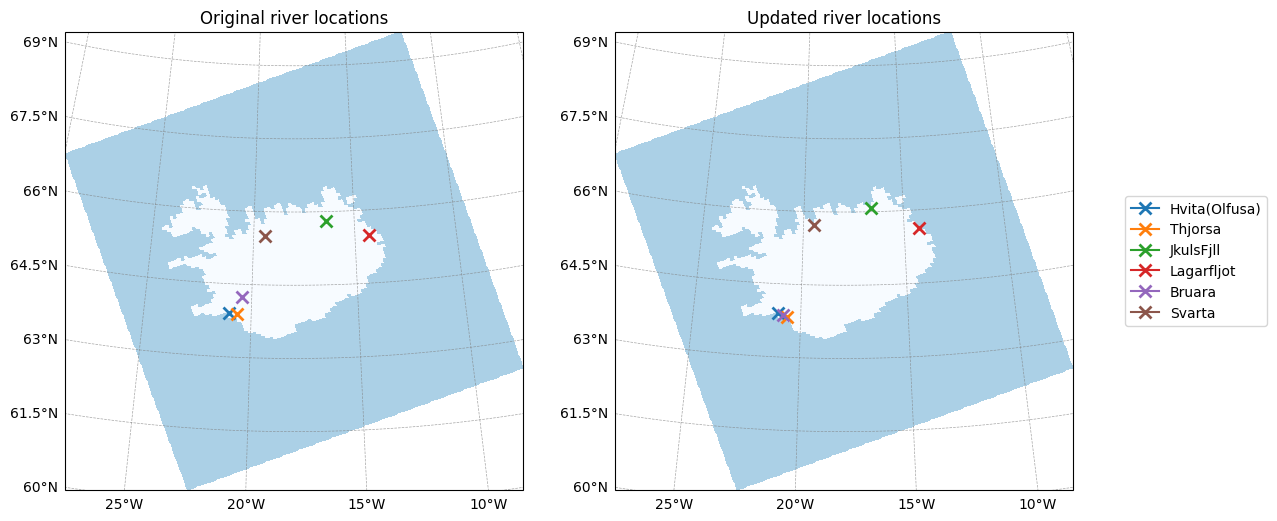

In [8]:
river_forcing.plot_locations()

The left plot shows the original river locations extracted from the global dataset, mapped onto the ROMS domain. However, you will notice that most of these locations do not lie along the coast. ROMS requires river locations to be placed on land, but adjacent to wet points. The right plot displays the updated river locations, where `ROMS-Tools` has moved the original points to the nearest coastal grid points. 

The updated river locations are stored in the `.indices` attribute, a dictionary where each key represents a river name, and the corresponding value is a list of tuples. Each tuple contains two elements: the first represents the `eta_rho` index, and the second represents the `xi_rho` index. In this case, each river is associated with a single tuple in the list.

In [9]:
river_forcing.indices

{'Hvita(Olfusa)': [(43, 28)],
 'Thjorsa': [(41, 30)],
 'JkulsFjll': [(62, 63)],
 'Lagarfljot': [(52, 74)],
 'Bruara': [(42, 29)],
 'Svarta': [(63, 46)]}

These updated coastal river locations are now also reflected in the `river_flux` variable.

In [10]:
river_forcing.ds["river_flux"]

<xarray.DataArray 'river_flux' (eta_rho: 102, xi_rho: 102)> Size: 83kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  River ID plus local volume fraction
    units:      none

This array contains many zeros! Let's extract and list only the non-zero values.

In [11]:
non_zero_values = river_forcing.ds["river_flux"].values
non_zero_values = non_zero_values[non_zero_values != 0].tolist()
non_zero_values

[3.0, 6.0, 2.0, 5.0, 4.0, 7.0]

<div class="alert alert-info">

Note

The `river_flux` variable contains zeros where no river is present. When a grid point represents a river, it is assigned a non-zero value according to the following partitioning rule:

```
    river_flux = river ID + fraction of the river's flux through the grid point.
```
For example, if River 3 spans 2 grid points, with half of its flux passing through each, the resulting value for `river_flux` at these points would be 3.5 (i.e., 3 + 0.5 for each grid point). This method allows the model to accurately represent rivers that span multiple grid points, ensuring that the river flux volume is correctly distributed over the multiple grid points.

If a river is confined to a single grid point (as is the case with what is created by `ROMS-Tools`), the `river_flux` will have a value of river ID + 1. For instance, if River 3 is located at a single grid point, the `river_flux` value will be 4.

</div>

Let's plot the spatial location of these 6 non-zero values.

In [12]:
import matplotlib.colors as mcolors

colors = ["gray", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
cmap = mcolors.ListedColormap(colors)

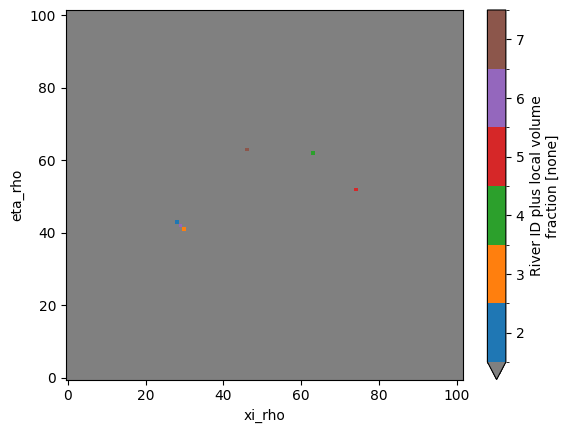

In [13]:
river_forcing.ds.river_flux.plot(
    levels=7, vmin=1.5, vmax=7.5, cmap=cmap, cbar_kwargs={"ticks": [2, 3, 4, 5, 6, 7]}
)

If you squint your eyes, you can see that the river locations in the `river_flux` variable align with the updated river locations shown in the previous plot on the right, marked with the same colors.

## Monthly versus climatological river forcing

Many river datasets contain missing values. To address this, `ROMS-Tools` offers the option to replace missing monthly values with climatological averages. 

In this first example, we choose the option to never use climatological values, ensuring that the river forcing is derived entirely from the available monthly data.

In [14]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    convert_to_climatology="never",  # "never", "always", or "if_any_missing" (default)
)

INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
WARNING - NaN values detected in the 'river_volume' field. These values are being set to zero. This may indicate missing river data, which could affect model accuracy. Consider setting `convert_to_climatology = 'if_any_missing'` to automatically fill missing values with climatological data.


CPU times: user 676 ms, sys: 173 ms, total: 848 ms
Wall time: 1.51 s


As we saw earlier in the notebook, the river forcing data is stored in an `xarray.Dataset`, which can be accessed via the `.ds` property.

In [15]:
river_forcing.ds

<xarray.Dataset> Size: 87kB
Dimensions:       (nriver: 6, river_time: 38, ntracers: 2, eta_rho: 102,
                   xi_rho: 102)
Coordinates:
    river_name    (nriver) object 48B 'Hvita(Olfusa)' 'Thjorsa' ... 'Svarta'
  * nriver        (nriver) int64 48B 1 2 3 4 5 6
    tracer_name   (ntracers) <U4 32B 'temp' 'salt'
    abs_time      (river_time) datetime64[ns] 304B 1997-12-15 ... 2001-01-15
  * river_time    (river_time) float64 304B -747.0 -716.0 -685.0 ... 349.0 380.0
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume  (river_time, nriver) float32 912B 0.0 0.0 0.0 ... 0.0 0.0
    river_tracer  (river_time, ntracers, nriver) float32 2kB 17.0 17.0 ... 1.0
    river_flux    (eta_rho, xi_rho) float64 83kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

As mentioned in the warning message when we created the river forcing, some of the river volume data contained NaN values, which have since been set to zero. Let’s take a closer look at this.

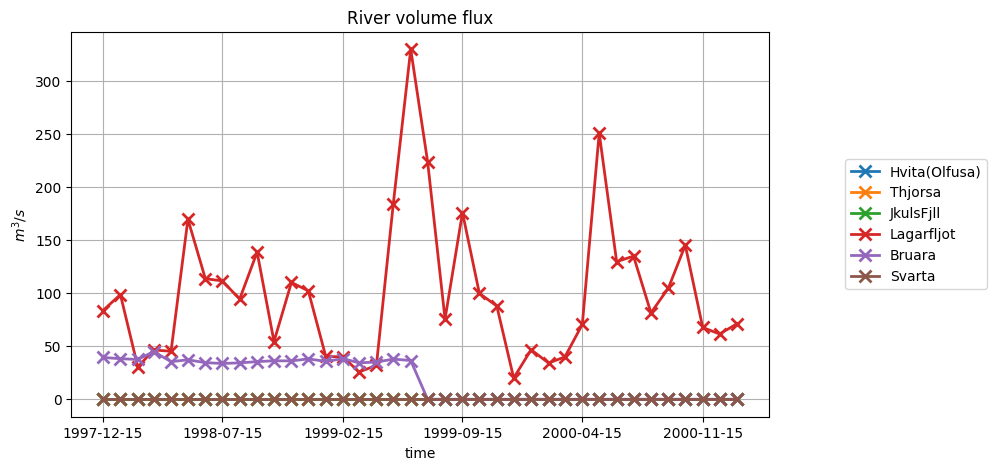

In [16]:
river_forcing.plot("river_volume")

Only the river Lagarfljot (red line) has a complete time series over our period of interest. The river Bruara (purple line) has missing values for roughly the second half of the period, which have been set to zero. All other rivers have missing values for the entire period and have also been set to zero.

The river tracer data, consisting of the river temperature and salinity, are not derived from the Dai and Trenberth dataset. Instead, they are always set to constant values: 17°C for temperature and 1 psu for salinity.

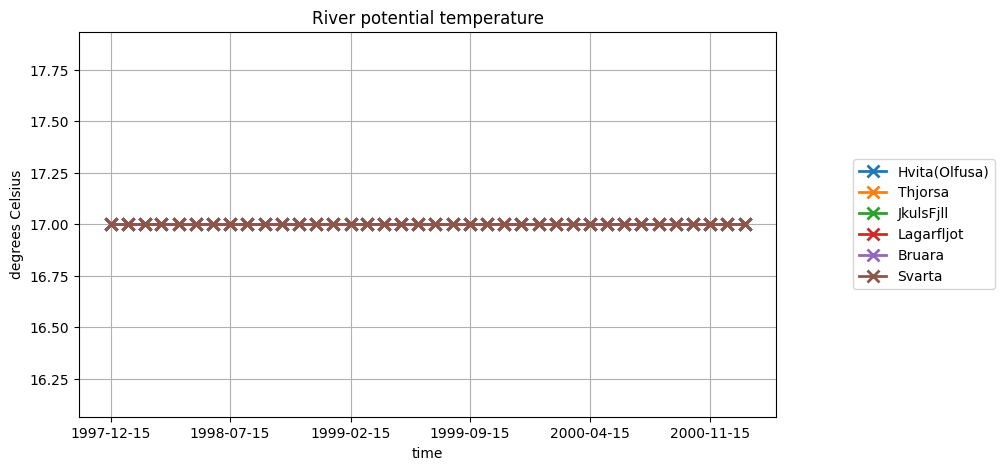

In [17]:
river_forcing.plot("river_temp")

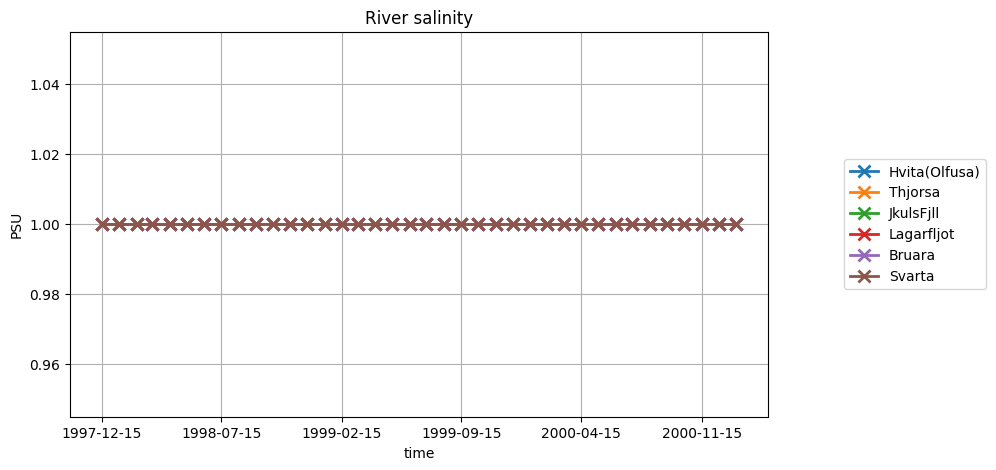

In [18]:
river_forcing.plot("river_salt")

We will now select the default option in `ROMS-Tools`, which converts the river volume data to climatological values if any missing values are detected.

In [19]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=datetime(1998, 1, 1),
    end_time=datetime(2000, 12, 31),
    convert_to_climatology="if_any_missing",  # "never", "always", or "if_any_missing" (default)
)

INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
INFO - Compute climatology for river forcing.


CPU times: user 719 ms, sys: 134 ms, total: 852 ms
Wall time: 1.48 s


The river forcing for all rivers is now represented as a climatology. Note that none of the rivers has a zero river volume flux in any month!

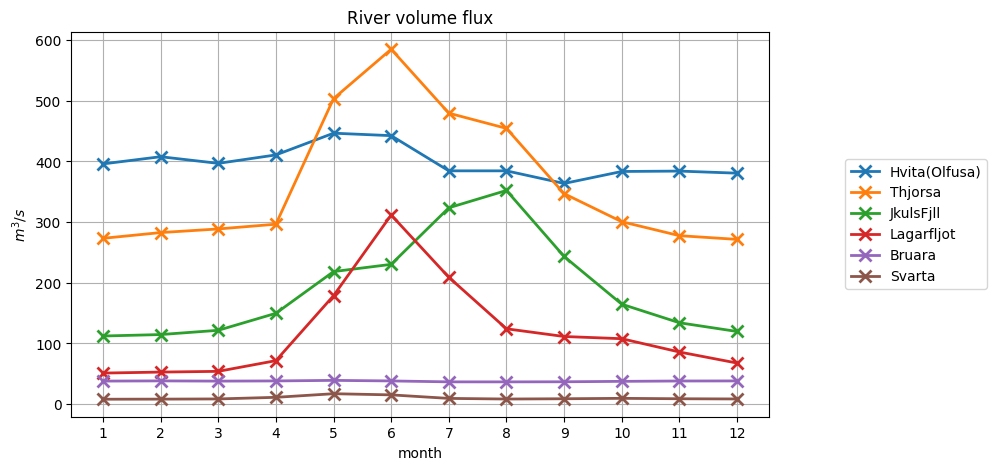

In [20]:
river_forcing.plot("river_volume")

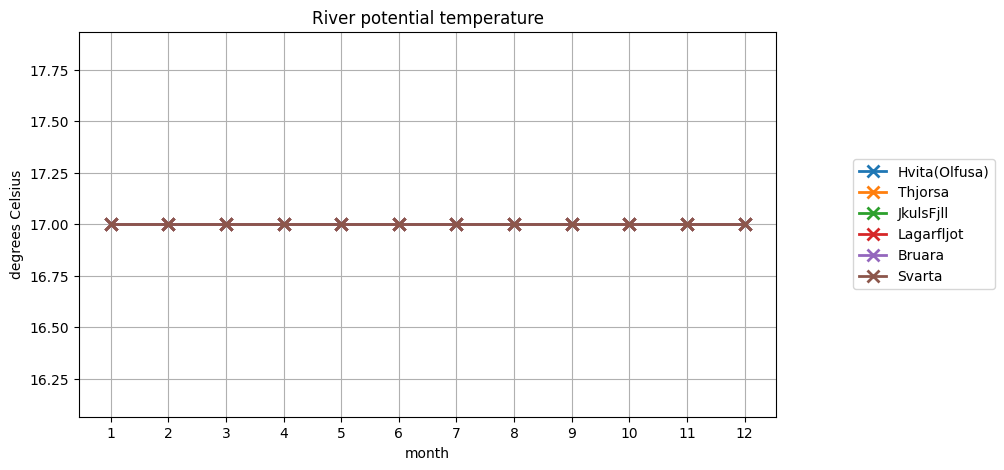

In [21]:
river_forcing.plot("river_temp")

## Adding BGC river forcing

To run a ROMS-MARBL simulation (i.e., ROMS with biogeochemistry), the model requires not only the standard two tracers (temperature and salinity) but also all 32 MARBL biogeochemical (BGC) tracers. If the river forcing data does not include all 32 BGC tracers, the model will crash. By setting `include_bgc_tracers = True`, `ROMS-Tools` can automatically add the required BGC tracers. However, this functionality is currently limited in that it sets all BGC tracers to zero. While this does not provide meaningful BGC data, it ensures that the simulation can run without crashing.

In [22]:
%%time

river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    include_bgc=True,  # default: False
)

INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
INFO - Compute climatology for river forcing.


CPU times: user 680 ms, sys: 173 ms, total: 853 ms
Wall time: 1.49 s


The river forcing data has now 34 = (2 + 32) tracers, as reflected by the `ntracers` dimension.

In [23]:
river_forcing.ds

<xarray.Dataset> Size: 95kB
Dimensions:       (river_time: 12, nriver: 6, ntracers: 34, eta_rho: 102,
                   xi_rho: 102)
Coordinates:
    month         (river_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    river_name    (nriver) object 48B 'Hvita(Olfusa)' 'Thjorsa' ... 'Svarta'
  * nriver        (nriver) int64 48B 1 2 3 4 5 6
    tracer_name   (ntracers) <U11 1kB 'temp' 'salt' 'PO4' ... 'diazP' 'diazFe'
    abs_time      (river_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * river_time    (river_time) float64 96B 15.0 45.0 74.0 ... 288.0 319.0 349.0
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume  (river_time, nriver) float32 288B 396.0 273.3 ... 38.2 8.47
    river_tracer  (river_time, ntracers, nriver) float32 10kB 17.0 17.0 ... 0.0
    river_flux    (eta_rho, xi_rho) float64 83kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    climatology:  True

Here are the tracer names.

In [24]:
river_forcing.ds.tracer_name

<xarray.DataArray 'tracer_name' (ntracers: 34)> Size: 1kB
array(['temp', 'salt', 'PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2',
       'DIC', 'DIC_ALT_CO2', 'ALK', 'ALK_ALT_CO2', 'DOC', 'DON', 'DOP',
       'DOPr', 'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe',
       'spCaCO3', 'diatChl', 'diatC', 'diatP', 'diatFe', 'diatSi',
       'diazChl', 'diazC', 'diazP', 'diazFe'], dtype='<U11')
Coordinates:
    tracer_name  (ntracers) <U11 1kB 'temp' 'salt' 'PO4' ... 'diazP' 'diazFe'
Dimensions without coordinates: ntracers
Attributes:
    long_name:  Tracer name

As mentioned before, the BGC tracers are simply set to zero.

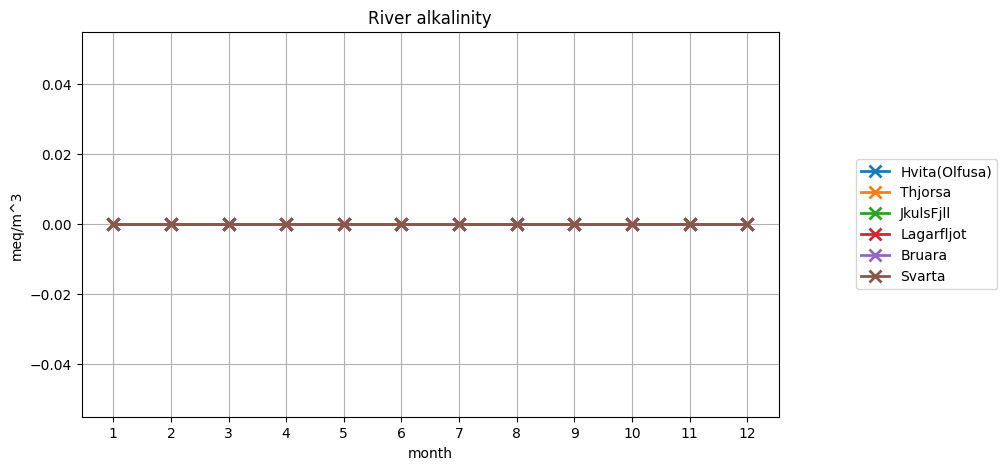

In [25]:
river_forcing.plot("river_ALK")

However, river temperature and salinity are still set to the same constant values as before: 17°C for temperature and 1 psu for salinity.

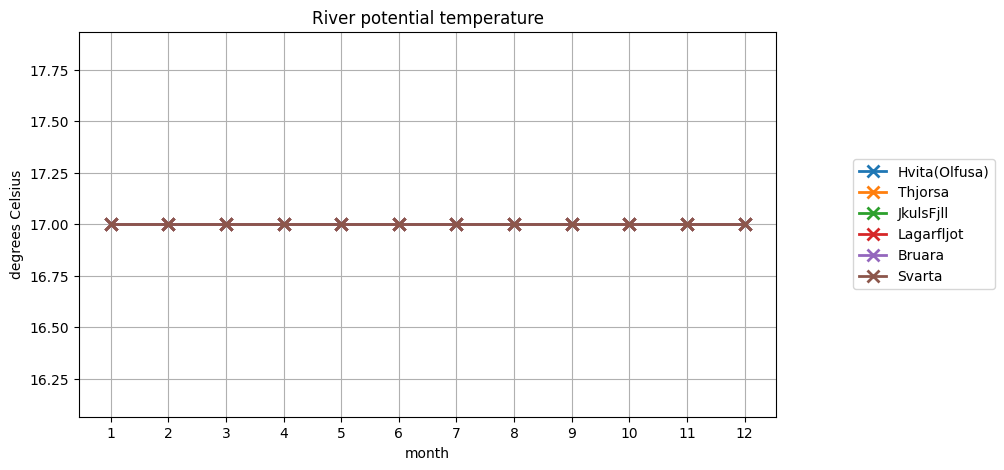

In [26]:
river_forcing.plot("river_temp")

## Saving as NetCDF or YAML file

We can now save our river forcing as a netCDF file via the `.save` method.

In [27]:
filepath = "/pscratch/sd/n/nloose/forcing/my_river_forcing.nc"

In [28]:
river_forcing.save(filepath=filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_river_forcing.nc


[PosixPath('/pscratch/sd/n/nloose/forcing/my_river_forcing.nc')]

We can also export the river forcing parameters to a YAML file.

In [29]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_river_forcing.yaml"

In [30]:
river_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [31]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev177
---
Grid:
  nx: 100
  ny: 100
  size_x: 800
  size_y: 800
  center_lon: -18
  center_lat: 65
  rot: 20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: ETOPO5
  hmin: 5.0
RiverForcing:
  start_time: '1998-01-01T00:00:00'
  end_time: '2000-12-31T00:00:00'
  source:
    name: DAI
    climatology: false
  convert_to_climatology: if_any_missing
  include_bgc: true
  model_reference_date: '2000-01-01T00:00:00'
  indices:
    _convention: eta_rho, xi_rho
    Hvita(Olfusa):
    - 43, 28
    Thjorsa:
    - 41, 30
    JkulsFjll:
    - 62, 63
    Lagarfljot:
    - 52, 74
    Bruara:
    - 42, 29
    Svarta:
    - 63, 46



## Creating river forcing from an existing YAML file

In [32]:
%time the_same_river_forcing = RiverForcing.from_yaml(yaml_filepath)

INFO - Use provided river indices.
INFO - Compute climatology for river forcing.


CPU times: user 1.64 s, sys: 117 ms, total: 1.76 s
Wall time: 2.5 s


## Prescribing the river indices

If you prefer not to use the default behavior of `ROMS-Tools`, where a river is automatically assigned to the nearest coastal cell, you can manually specify the river indices. This may be useful in scenarios such as:

- A river is mistakenly assigned to the wrong fjord or estuary when multiple of these are located near the original river mouth location.  
- You wish to define a river that spans multiple cells.

In these cases, you can provide `ROMS-Tools` with a custom `indices` dictionary when creating the `RiverForcing`.

### Specifying valid river indices

To begin, let's first use the dictionary that `ROMS-Tools` automatically generated for our river forcing above.

In [33]:
indices = river_forcing.indices
indices

{'Hvita(Olfusa)': [(43, 28)],
 'Thjorsa': [(41, 30)],
 'JkulsFjll': [(62, 63)],
 'Lagarfljot': [(52, 74)],
 'Bruara': [(42, 29)],
 'Svarta': [(63, 46)]}

In [34]:
yet_the_same_river_forcing = RiverForcing(
    grid=grid, start_time=start_time, end_time=end_time, indices=indices
)

INFO - Use provided river indices.
INFO - Compute climatology for river forcing.


If the `indices` are specified, `ROMS-Tools` will not modify them. This is confirmed by the following plot, where the original river locations align exactly with the updated ones.

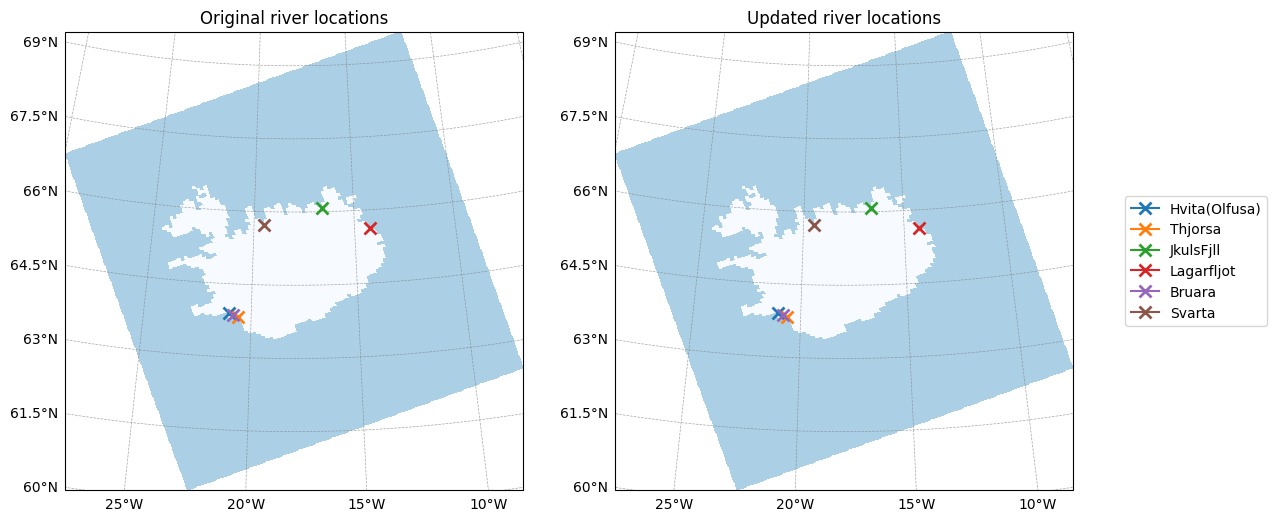

In [35]:
yet_the_same_river_forcing.plot_locations()

Next, let's define some multi-cell rivers. The convention for specifying river locations is to use tuples in the format (`eta_rho`, `xi_rho`).  

In [36]:
multi_cell_indices = {
    "Hvita(Olfusa)": [(43, 28)],
    "Thjorsa": [(41, 30)],
    "JkulsFjll": [(62, 63)],
    "Lagarfljot": [(52, 74)],
    "Bruara": [(42, 29)],
    "Svarta": [(63, 46), (64, 45), (65, 45), (64, 47)],
}

In [37]:
multi_cell_river_forcing = RiverForcing(
    grid=grid, start_time=start_time, end_time=end_time, indices=multi_cell_indices
)

INFO - Use provided river indices.
INFO - Compute climatology for river forcing.


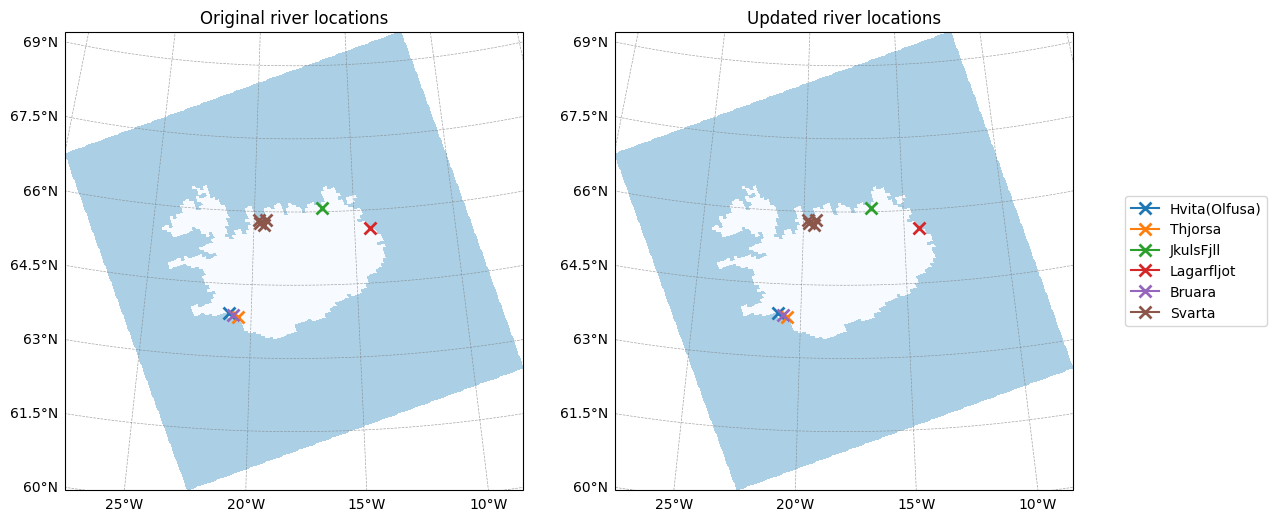

In [38]:
multi_cell_river_forcing.plot_locations()

Let's verify that the rivers are also correctly represented in the `multi_cell_river_forcing.ds["river_location"]` variable.

In [39]:
non_zero_values = multi_cell_river_forcing.ds["river_flux"].values
non_zero_values = non_zero_values[non_zero_values != 0].tolist()
non_zero_values

[3.0, 6.0, 2.0, 5.0, 4.0, 6.25, 6.25, 6.25, 6.25]

You can see that the river with ID 6 (Svarta, shown in brown in the figure above) is now represented by four entries, each calculated as:

```
river ID + fraction = 6 + 0.25 = 6.25
```

We can write and read multi-cell rivers to and from YAML as usual.

In [40]:
multi_cell_yaml_filepath = (
    "/pscratch/sd/n/nloose/forcing/my_multi_cell_river_forcing.yaml"
)

In [41]:
multi_cell_river_forcing.to_yaml(multi_cell_yaml_filepath)

In [42]:
# Open and read the YAML file
with open(multi_cell_yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev177
---
Grid:
  nx: 100
  ny: 100
  size_x: 800
  size_y: 800
  center_lon: -18
  center_lat: 65
  rot: 20
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: ETOPO5
  hmin: 5.0
RiverForcing:
  start_time: '1998-01-01T00:00:00'
  end_time: '2000-12-31T00:00:00'
  source:
    name: DAI
    climatology: false
  convert_to_climatology: if_any_missing
  include_bgc: false
  model_reference_date: '2000-01-01T00:00:00'
  indices:
    _convention: eta_rho, xi_rho
    Hvita(Olfusa):
    - 43, 28
    Thjorsa:
    - 41, 30
    JkulsFjll:
    - 62, 63
    Lagarfljot:
    - 52, 74
    Bruara:
    - 42, 29
    Svarta:
    - 63, 46
    - 64, 45
    - 65, 45
    - 64, 47



In [43]:
the_same_multi_cell_river_forcing = RiverForcing.from_yaml(multi_cell_yaml_filepath)

INFO - Use provided river indices.
INFO - Compute climatology for river forcing.


### Specifying invalid river indices
As discussed above, each river must be located in one or more coastal cells—meaning they must be on land but adjacent to a wet point. If the specified indices do not meet this requirement, attempting to create a `RiverForcing` object will result in an error, as seen in the next example.

In [44]:
invalid_cell_indices = {
    "Hvita(Olfusa)": [(0, 28)],  # (eta_rho, xi_rho) = (0, 28) is not a coastal point
    "Thjorsa": [(41, 30)],
    "JkulsFjll": [(62, 63)],
    "Lagarfljot": [(52, 74)],
    "Bruara": [(42, 29)],
    "Svarta": [(63, 46), (64, 45), (65, 45), (64, 47)],
}

In [45]:
RiverForcing(
    grid=grid, start_time=start_time, end_time=end_time, indices=invalid_cell_indices
)

INFO - Use provided river indices.


ValueError: River `Hvita(Olfusa)` is not located on the coast at grid cell (0, 28).